# Objective: train a model to classify face mask (with a pretained model)

# Homework on real world dataset : Face Mask Image
![alt text](https://raw.githubusercontent.com/AIZOOTech/FaceMaskDetection/master/img/demo.png)

Detect faces and determine whether masks are worn or not.

Dataset from : [AIZOOTech/FaceMaskDetection](https://github.com/AIZOOTech/FaceMaskDetection)

In this assignment you have to replace YOUR_STUDENT_ID_WITH21 variable with your student id (in integer). There will be 3 sets of data: train, test and validation in the following folders:

*   facemask/train (with labels)
*   facemask/test (with labels)
*   facemask/val (unknown label)

By using the knowledge from the lab and lecture, you have to design your own CNN face mask image classification model and tested on unknown label dataset!



Scoreboard URL : https://pic.cp.eng.chula.ac.th/classes/ai4engineer/

In [ ]:
#import libraries

import random
import glob
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

##### Don't forget to put your ID here (in integer) ####
YOUR_STUDENT_ID_WITH21 = 5930504121
#######################################################

def isStudentIDValid(studentID):
  strID = str(studentID)
  isEndWith21 = strID.endswith('21')
  isLengthOK = len(strID) == 10
  if isEndWith21 and isLengthOK:
    return True
  else:
    return False

print('Student ID status:',isStudentIDValid(YOUR_STUDENT_ID_WITH21))

Student ID status: True


##GPU Status Check

In [ ]:
!nvidia-smi

Thu Apr 16 15:51:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    24W /  75W |   7609MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Download and inspect face mask dataset

In [ ]:
!wget  -O facemask.zip https://pic.cp.eng.chula.ac.th/facemask.zip
!unzip -qo facemask.zip

--2020-04-16 15:51:33--  https://pic.cp.eng.chula.ac.th/facemask.zip
Resolving pic.cp.eng.chula.ac.th (pic.cp.eng.chula.ac.th)... 161.200.92.132
Connecting to pic.cp.eng.chula.ac.th (pic.cp.eng.chula.ac.th)|161.200.92.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52616636 (50M) [application/zip]
Saving to: ‘facemask.zip’

facemask.zip        100%[===================>]  50.18M  10.2MB/s    in 7.1s    

2020-04-16 15:51:42 (7.05 MB/s) - ‘facemask.zip’ saved [52616636/52616636]



In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [ ]:
#### FILL Any Augmenetation HERE ####
transformTrain = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(192),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

transformTest =  transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
### Load Dataset ###
faceMaskTrainDataset = ImageFolder('facemask/train/', transform=transformTrain)
faceMaskTestDataset = ImageFolder('facemask/test/', transform=transformTest)

In [ ]:
print('Total train set images :', len(faceMaskTrainDataset))
print('Total test set images :', len(faceMaskTestDataset))

Total train set images : 4706
Total test set images : 1739


## Dataset Visualization

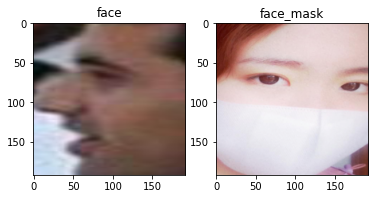

In [ ]:
normalImage, normalClassName = getImageFromDataset(faceMaskTrainDataset, 0)
maskImage, maskClassName = getImageFromDataset(faceMaskTrainDataset, 4000)

_, figure = plt.subplots(1,2)

figure[0].imshow(normalImage,cmap='gray')
figure[0].title.set_text(normalClassName)

figure[1].imshow(maskImage,cmap='gray')
figure[1].title.set_text(maskClassName)
plt.show()

## Train the model

In [ ]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader), ncols='100%')
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData
      
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )
    
      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):
  
  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:', ncols='100%'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader), ncols='100%')
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)
    
      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)
    
      loss.backward()
      optimizer.step()
      

      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)
    
    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

**MODEL**

In [ ]:
#transfer learning

pretrainNet = models.resnet18(pretrained=True)
pretrainNet.fc = nn.Linear(512,2)
pretrainNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(pretrainNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

fastenerTrainDatasetLoader = DataLoader(faceMaskTrainDataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
fastenerTestDatasetLoader = DataLoader(faceMaskTestDataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(fastenerTrainDatasetLoader, fastenerTestDatasetLoader, 
                                                                    pretrainNet, 
                                                                    optimizer, scheduler, criterion, 
                                                                    trainEpoch=10)

Epoch 1 / 10



Epoch 2 / 10



Epoch 3 / 10



Epoch 4 / 10



Epoch 5 / 10



Epoch 6 / 10



Epoch 7 / 10



Epoch 8 / 10



Epoch 9 / 10



Epoch 10 / 10


## Find the confusion matrix and calculate TP, TN, FP, and FN

In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

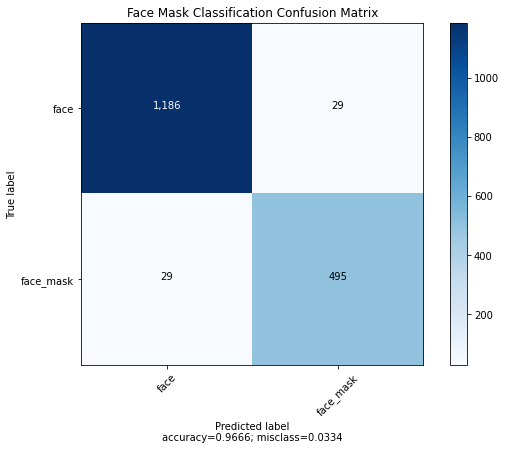

TP:1186 TN:29 FP:29 FN:495


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix, 
                      normalize    = False,
                      target_names = faceMaskTrainDataset.classes,
                      title        = "Face Mask Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

## Classify on validation set and send result to server!

In [ ]:
from PIL import Image
import json
import requests

class ImageFolderWithPaths(Dataset):
    def __init__(self, root_dir, transform=None):
        self.imageFileNames = sorted(glob.glob(root_dir+'/*.jpg'))
        self.transform = transform
    
    def __getitem__(self, idx):
        imageData = Image.open(self.imageFileNames[idx])
        imageFileName = os.path.basename(self.imageFileNames[idx])
        if self.transform is not None:
            imageData = self.transform(imageData)
        return imageFileName, imageData.unsqueeze(0)
    def __len__(self):
        return len(self.imageFileNames)



def generatePredictedResults(valDataset, net):
    net.eval()
    predictedResults = {}
    with torch.no_grad():
        for imageFileName, imageData in tqdm(valDataset, ncols='100%'):
            imageData = imageData.cuda()
            outputs = net(imageData)
            _, predicted = torch.max(outputs, 1)
            #print(imageFileName, predicted.item())
            predictedResults[imageFileName] =  predicted.item()
    return predictedResults

def sendResult(predictedResults,studentID=5871451121):
    sendDict = { 'studentID':studentID, 'results':  predictedResults }
    response = requests.post('https://pic.cp.eng.chula.ac.th/classes/ai4engineer/submit',headers={'Content-Type': 'application/json' }, json=sendDict)
    return response.text


In [ ]:
faceMaskValDataset = ImageFolderWithPaths('facemask/val/', transform=transformTest)
predictedResults = generatePredictedResults(faceMaskValDataset, bestNet)
print(sendResult(predictedResults, studentID=YOUR_STUDENT_ID_WITH21))


{"accuracy":"96.25","status":"SUCCESS"}

